In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
import os
len(os.listdir('/gdrive/MyDrive/hy/data/0')),len(os.listdir('/gdrive/MyDrive/hy/data/1')),len(os.listdir('/gdrive/MyDrive/hy/data/2'))

(1008, 1008, 976)

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Define parameters
image_size = (224, 224)
batch_size = 32
DATA_DIR = '/gdrive/MyDrive/hy/data'
num_classes = len(os.listdir(DATA_DIR))  # Assuming each folder corresponds to a class

# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Create data generator with validation split
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split the data into 80% training and 20% validation
)

# Create a single generator for both training and validation
data_generator = data_generator.flow_from_directory(
    DATA_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',  # Assuming you have numerical labels
    subset='training'  # Specify 'validation' for the validation subset
)

Found 2395 images belonging to 3 classes.


In [5]:
# Train the model
history = model.fit(
    data_generator,
    epochs=10,
    validation_data=data_generator
)

Epoch 1/10
75/75 [==============================] - 209s 2s/step - loss: 0.1220 - accuracy: 0.9649 - val_loss: 11.0065 - val_accuracy: 0.3261
Epoch 2/10
75/75 [==============================] - 91s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 10.9545 - val_accuracy: 0.3261
Epoch 3/10
75/75 [==============================] - 91s 1s/step - loss: 0.0193 - accuracy: 0.9950 - val_loss: 3.6313 - val_accuracy: 0.3261
Epoch 4/10
75/75 [==============================] - 131s 2s/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 1.0989 - val_accuracy: 0.3370
Epoch 5/10
75/75 [==============================] - 90s 1s/step - loss: 0.0489 - accuracy: 0.9875 - val_loss: 1.1024 - val_accuracy: 0.3261
Epoch 6/10
75/75 [==============================] - 91s 1s/step - loss: 0.1609 - accuracy: 0.9737 - val_loss: 1.1298 - val_accuracy: 0.3261
Epoch 7/10
75/75 [==============================] - 92s 1s/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 1.1321 - val_accuracy: 0.3261
Epoch 8/10
75/75

In [6]:
# Save the trained model to a file
model.save('res_trained_model.h5')

# Optionally, you can also save the history object for future reference
import pickle

with open('training_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

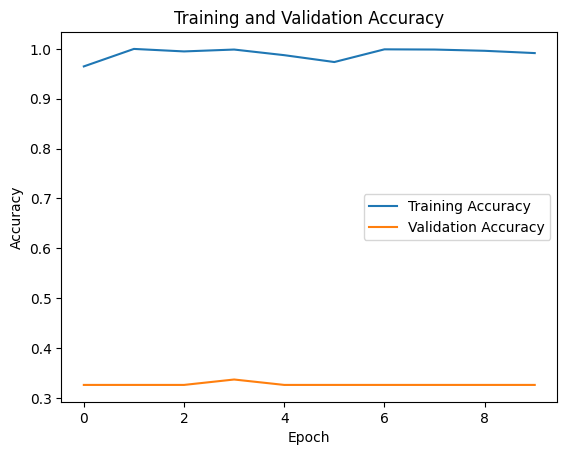

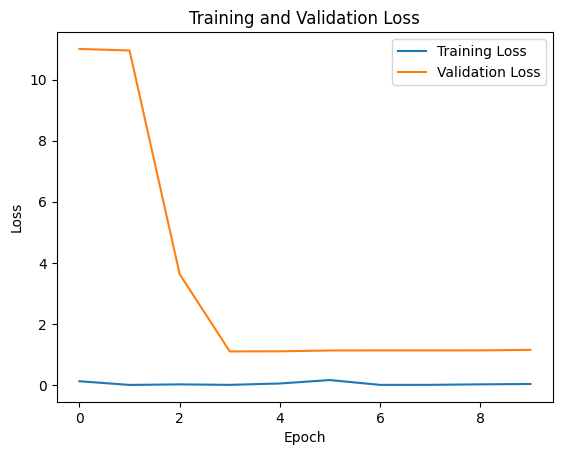

In [7]:
import matplotlib.pyplot as plt

# ... (previous code)

# Access training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [9]:
# Evaluate on the test set
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator = data_generator.flow_from_directory(
    DATA_DIR,  # Provide the path to your test data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # Important to keep the order for evaluation
)

test_loss, test_accuracy = model.evaluate(test_data_generator)
print(f"Test accuracy: {test_accuracy}")


Found 2992 images belonging to 3 classes.
94/94 [==============================] - 68s 725ms/step - loss: 1.1488 - accuracy: 0.3262
Test accuracy: 0.32620319724082947


In [12]:
from sklearn.metrics import classification_report

# Assuming you have ground truth labels for the validation data
true_labels = test_data_generator.classes

# Make predictions
predictions = model.predict(test_data_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_labels)
print(report)


94/94 [==============================] - 55s 576ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1008
           1       0.00      0.00      0.00      1008
           2       0.33      1.00      0.49       976

    accuracy                           0.33      2992
   macro avg       0.11      0.33      0.16      2992
weighted avg       0.11      0.33      0.16      2992



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
